# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [1]:
from dotenv import load_dotenv, find_dotenv
import os 

langsmith_key = os.getenv('LANGSMITH_API_KEY')
_ = load_dotenv(find_dotenv())

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("ollama:gpt-oss:20b-cloud", temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [3]:
result = llm.invoke("What is an agent?")

In [4]:
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='**Agent – a quick snapshot**\n\n| Context | What it means | Typical examples |\n|---------|---------------|------------------|\n| **Human/Organizational** | A person or entity that represents, acts for, or manages the interests of another (the “principal”). | Real‑estate agent, insurance broker, talent agent, corporate liaison. |\n| **Economic/Principal‑Agent Theory** | The “agent” is the party that performs tasks on behalf of the principal, often with a contractual relationship that may involve incentives, monitoring, or risk‑sharing. | A CEO hired by shareholders, a consultant hired by a firm. |\n| **Software / Computer Science** | A program or process that perceives its environment (via sensors or data) and takes actions (via actuators or outputs) to achieve a goal or set of goals. | Chatbot, web crawler, automated trading bot. |\n| **Artificial Intelligence** | An autonomous or semi‑autonomous entity that observes, decides, and acts in an environment to maximize 

In [6]:
from rich.markdown import Markdown
Markdown(result.content)

Agent – a quick snapshot                                                                                           

                                                                                                                   
  Context                           What it means                           Typical examples                       
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Human/Organizational              A person or entity that represents,     Real‑estate agent, insurance broker,   
                                    acts for, or manages the interests of   talent agent, corporate liaison.       
                                    another (the “principal”).                                                     
  Economic/Principal‑Agent Theory   The “agent” is the party that           A CEO hired by shareholders, a         
                                    performs tasks on behalf of the         consultant hired by a firm.            
                                    principal, often with a contractual                                            
                                    relationship that may involve                                                  
                                    incentives, monitoring, or                                                     
                                    risk‑sharing.                                                                  
  Software / Computer Science       A program or process that perceives     Chatbot, web crawler, automated        
                                    its environment (via sensors or data)   trading bot.                           
                                    and takes actions (via actuators or                                            
                                    outputs) to achieve a goal or set of                                           
                                    goals.                                                                         
  Artificial Intelligence           An autonomous or semi‑autonomous        A reinforcement‑learning agent in a    
                                    entity that observes, decides, and      game, a self‑driving car’s control     
                                    acts in an environment to maximize      system.                                
                                    some notion of cumulative reward or                                            
                                    utility.                                                                       
  Legal / Regulatory                An entity that has the authority to     Power‑of‑attorney holder, legal        
                                    act on behalf of another in legal or    representative.                        
                                    regulatory matters.                                                            
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                               Why the term matters                                                

 • Delegation & Representation – Agents allow principals to outsource tasks, leverage expertise, or act in         
   situations where direct action is impractical.                                                                  
 • Autonomy & Decision‑Making – In AI, an agent’s autonomy is what distinguishes it from a simple script; it must  
   perceive, reason, and act without constant human intervention.                                                  
 • Accountability & Incentives – In economics and law, the agent’s behavior is governed by contracts, incentives,  
   and monitoring mechanisms to align interests with 

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [7]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [8]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [9]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [10]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

In [11]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="any")#, parallel_tool_calls=False)

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [12]:
type(output)

langchain_core.messages.ai.AIMessage

In [13]:
output

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b-cloud', 'created_at': '2025-09-25T17:21:54.774312855Z', 'done': True, 'done_reason': 'tool_calls', 'total_duration': 2050478606, 'load_duration': None, 'prompt_eval_count': 149, 'prompt_eval_duration': None, 'eval_count': 313, 'eval_duration': None, 'model_name': 'gpt-oss:20b-cloud'}, id='run--ac6e84ea-65d6-4900-814f-09e234b8ba90-0', tool_calls=[{'name': 'write_email', 'args': {'content': 'Hi [Boss Name], \n\nThank you for scheduling tomorrow’s meeting. I’ll be there and look forward to discussing the agenda items. Could you please share any pre‑read materials or specific topics you’d like me to prepare for? \n\nThanks again, \n[Your Name]', 'subject': 'Re: Tomorrow’s Meeting', 'to': 'boss@company.ai'}, 'id': '7fdf5f11-ffcf-4a4b-885f-8fcdf9e2174d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 313, 'total_tokens': 462})

In [14]:
output.tool_calls[0]

{'name': 'write_email',
 'args': {'content': 'Hi [Boss Name], \n\nThank you for scheduling tomorrow’s meeting. I’ll be there and look forward to discussing the agenda items. Could you please share any pre‑read materials or specific topics you’d like me to prepare for? \n\nThanks again, \n[Your Name]',
  'subject': 'Re: Tomorrow’s Meeting',
  'to': 'boss@company.ai'},
 'id': '7fdf5f11-ffcf-4a4b-885f-8fcdf9e2174d',
 'type': 'tool_call'}

In [15]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'content': 'Hi [Boss Name], \n\nThank you for scheduling tomorrow’s meeting. I’ll be there and look forward to discussing the agenda items. Could you please share any pre‑read materials or specific topics you’d like me to prepare for? \n\nThanks again, \n[Your Name]',
 'subject': 'Re: Tomorrow’s Meeting',
 'to': 'boss@company.ai'}

In [16]:
# Call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow’s Meeting' and content: Hi [Boss Name],                   

Thank you for scheduling tomorrow’s meeting. I’ll be there and look forward to discussing the agenda items. Could  
you please share any pre‑read materials or specific topics you’d like me to prepare for?                           

Thanks again, [Your Name]

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

In [17]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [18]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [19]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [20]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Confirmation for Tomorrow’s Meeting' and content: Hi [Boss Name],\n\nI just wanted to confirm that I’m all set for tomorrow’s meeting. I’ve reviewed the agenda items and have prepared the updates on the project milestones, budget status, and the upcoming sprint plan. If there’s anything specific you’d like me to focus on or any additional materials you need beforehand, please let me know.\n\nLooking forward to our discussion.\n\nBest regards,\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [25]:
from typing import Literal
from langgraph.graph import MessagesState
#from email_assistant.utils import show_graph
from IPython.display import Image


def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: MessagesState):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

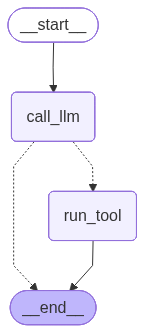

In [27]:
# View graph of workflow
display(Image(app.get_graph().draw_mermaid_png()))

#show_graph(app)   ----> this works only with from email_assistant.utils import show_graph

In [28]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (16f91364-fbec-4c00-b6a8-d38da3a8071d)
 Call ID: 16f91364-fbec-4c00-b6a8-d38da3a8071d
  Args:
    content: Dear [Boss Name],

I hope you’re doing well. I am writing to confirm that I will be attending Interrupt! as scheduled. I’m looking forward to the event and the opportunity to engage with the community and share our latest initiatives.

Please let me know if there are any specific items you’d like me to prepare or present during the conference.

Thank you for the opportunity.

Best regards,
[Your Name]
    subject: Confirmation of Attendance at Interrupt!
    to: boss@company.ai
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confi

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [29]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (ea0a896d-dcdc-4617-85dd-000e55644940)
 Call ID: ea0a896d-dcdc-4617-85dd-000e55644940
  Args:
    content: Hi [Boss's Name],

I hope you’re doing well. I’m writing to confirm that I will be attending Interrupt! as discussed. I’m looking forward to the event and the opportunity to engage with the community.

Please let me know if there’s anything specific you’d like me to prepare or any additional details I should be aware of.

Thank you for the opportunity.

Best regards,
[Your Name]
    subject: Confirmation of Attendance at Interrupt!
    to: boss@company.ai
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmati

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [30]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

In [31]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some tried‑and‑true best practices that help you write clear, professional, and effective emails:

| # | Practice | Why it matters | Quick Tips |
|---|----------|----------------|------------|
| 1 | **Use a concise, descriptive subject line** | The subject is the first thing the recipient sees; it determines whether the email gets opened. | • Keep it 5–7 words.<br>• Include key info (e.g., “Q3 Budget Review – Action Needed”). |
| 2 | **Start with a polite greeting** | Sets a respectful tone and personalizes the message. | • “Hi [Name],” or “Dear [Name],” for formal contexts. |
| 3 | **Get to the point quickly** | Busy people skim emails; a clear opening saves time. | • First sentence: state the purpose or request.<br>• Use bullet points for multiple items. |
| 4 | **K

In [32]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss confirming that I want to attend Interrupt"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some tried‑and‑true best practices that help you write clear, professional, and effective emails:

| # | Practice | Why it matters | Quick Tips |
|---|----------|----------------|------------|
| 1 | **Use a concise, descriptive subject line** | The subject is the first thing the recipient sees; it determines whether the email gets opened. | • Keep it 5–7 words.<br>• Include key info (e.g., “Q3 Budget Review – Action Needed”). |
| 2 | **Start with a polite greeting** | Sets a respectful tone and personalizes the message. | • “Hi [Name],” or “Dear [Name],” for formal contexts. |
| 3 | **Get to the point quickly** | Busy people skim emails; a clear opening saves time. | • First sentence: state the purpose or request.<br>• Use bullet points for multiple items. |
| 4 | **K

In [33]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some tried‑and‑true best practices that help you write clear, professional, and effective emails:

| # | Practice | Why it matters | Quick Tips |
|---|----------|----------------|------------|
| 1 | **Use a concise, descriptive subject line** | The subject is the first thing the recipient sees; it determines whether the email gets opened. | • Keep it 5–7 words.<br>• Include key info (e.g., “Q3 Budget Review – Action Needed”). |
| 2 | **Start with a polite greeting** | Sets a respectful tone and personalizes the message. | • “Hi [Name],” or “Dear [Name],” for formal contexts. |
| 3 | **Get to the point quickly** | Busy people skim emails; a clear opening saves time. | • First sentence: state the purpose or request.<br>• Use bullet points for multiple items. |
| 4 | **K

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [43]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

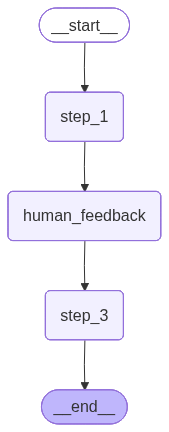

In [45]:
# View graph of workflow
display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [42]:
#from email_assistant.utils import show_graph
#show_graph(graph)

In [46]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='968102ec4cdcfe5d40b8b6c35a1f0e35'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [47]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs